<a href="https://colab.research.google.com/github/DanielEXT10/AI/blob/main/Electronic_boards_condition_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electronic Boards condition

A traves de un sistema de aprendizaje no supervisado se busca clasificar

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


# Carga del dataset
El dataset contiene un listado de las corridas(trabajos de perforacion) realizados, junto con el componente electronico presente y las condiciones bajo las cuales trabajo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Proyecto de innovacion/Run Exposure.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
data['FCSN']= data['FileCode'] + '.' + data['SN']

## Analisis Exploratorio de los Datos (EDA)

El analisis exploratorio de datos nos apoyaremos de la libreria **pandas-profile**, analizaremos el status de nuestro set de datos, en busca de valores faltantes y patrones basicos en la data.

(Despues de correr la primer celda ver en la seccion de documentos "Boards_report.html")

In [ ]:
data.columns

Index(['FileCode', 'SN', 'Description', 'RunID', 'StartDate', 'EndDate',
       'Max Temp', 'Hrs Temp[<130]', 'Hrs Temp[130-150]', 'Hrs Temp[150-175]',
       'Hrs Temp[>175]', 'Hrs Temp[>153]', 'Shock Risk', 'Pumping Hrs',
       'Data Source', 'Reason for POOH', 'Country', 'Operator', 'FCSN'],
      dtype='object')

In [ ]:
data = data[:-2]

In [ ]:
data = data[data['Max Temp'] < 190]

In [ ]:
data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
StartDate,36446,2018-06-14 19:12:52.627997440,2009-05-16 00:00:00,2015-05-20 00:00:00,2019-02-21 00:00:00,2021-10-18 00:00:00,2023-03-07 00:00:00,NaN
EndDate,36435,2018-06-20 19:29:30.506381056,2009-05-21 00:00:00,2015-05-27 00:00:00,2019-02-26 00:00:00,2021-10-23 00:00:00,2023-03-10 00:00:00,NaN
Max Temp,36446.0,81.078094,3.0,53.0,80.0,105.0,184.0,33.71032
Hrs Temp[<130],35812.0,87.081425,0.0,36.9,67.002778,112.0,1323.002778,77.920164
Hrs Temp[130-150],36424.0,6.754755,0.0,0.0,0.0,0.0,326.647222,28.297095
Hrs Temp[150-175],36424.0,0.691463,0.0,0.0,0.0,0.0,191.0,7.973888
Hrs Temp[>175],36424.0,0.000883,0.0,0.0,0.0,0.0,23.569444,0.126206
Hrs Temp[>153],36446.0,0.666558,0.0,0.0,0.0,0.0,193.866667,7.961799
Pumping Hrs,35990.0,75.121781,0.0,28.0,55.4,97.4,560.4,70.851174


In [ ]:
data.dtypes

,0
FileCode,object
SN,object
Description,object
RunID,object
StartDate,datetime64[ns]
EndDate,datetime64[ns]
Max Temp,float64
Hrs Temp[<130],float64
Hrs Temp[130-150],float64
Hrs Temp[150-175],float64


In [ ]:
data['Reason for POOH'].drop_duplicates()

,Reason for POOH
0,Change Bottom Hole Assembly (non-failure)
1,Run Logs (Not TD)
2,Section Total Depth
3,Well Total Depth
7,Hole Problems
10,Drill Plug
31,Downhole Tool Failure (MLWD/DTR/Bit)
35,Downhole Steerable Tool Failure
37,Condition Mud - Well
57,NaN


In [ ]:
failure_list = ['Downhole Tool Failure (MLWD/DTR/Bit)','Downhole Steerable Tool Failure','Downhole String Failure','Lost in Hole']

In [ ]:
data[data['Reason for POOH'] == 'Downhole Tool Failure (MLWD/DTR/Bit)'].shape


(1592, 19)

In [ ]:
max_temp =data.groupby('FCSN')['Max Temp'].max().reset_index()

In [ ]:
max_temp.describe()

,Max Temp
count,894.000000
mean,140.152026
std,24.115754
min,34.000000
25%,133.000000
50%,148.000000
75%,155.000000
max,184.000000


Text(0.5, 1.0, 'HSTemp Max Temperature Distribution')

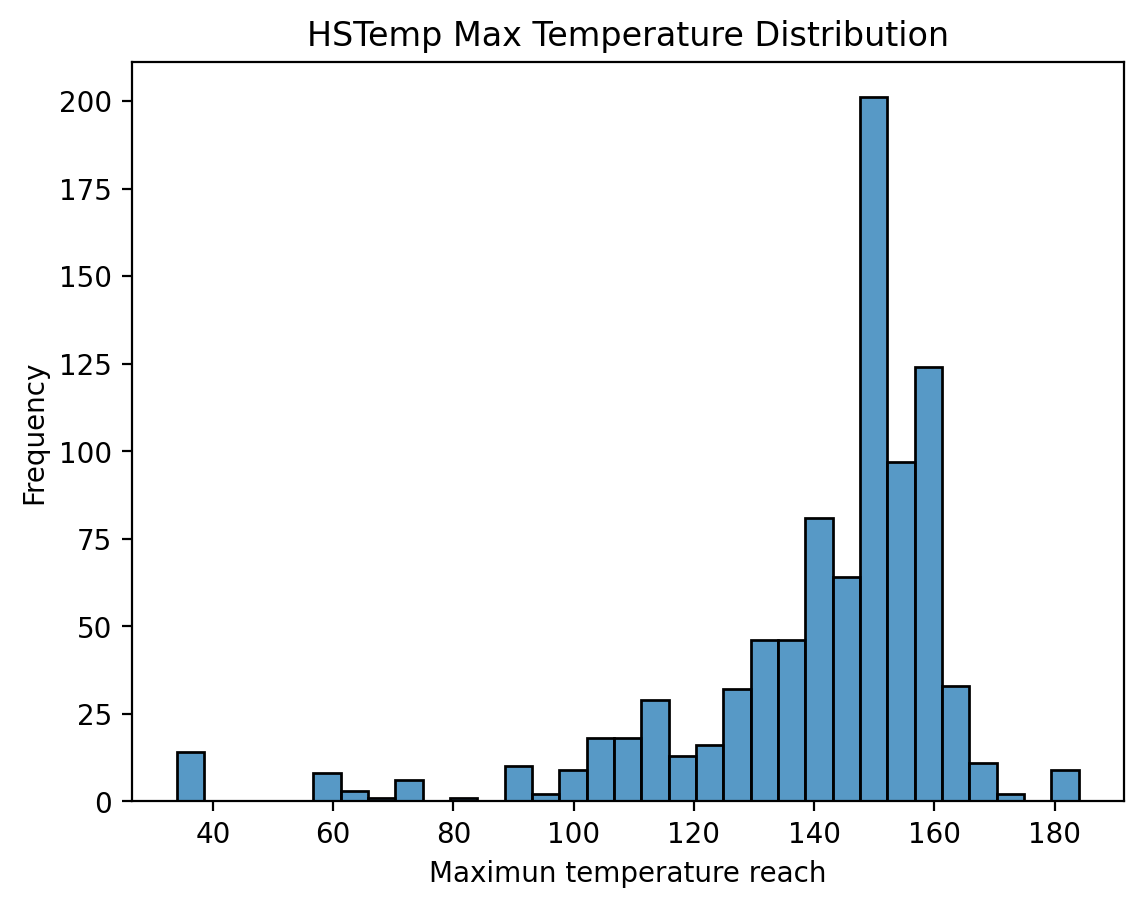

In [ ]:
sns.histplot(max_temp['Max Temp'], kde= False)
plt.xlabel('Maximun temperature reach')
plt.ylabel('Frequency')
plt.title('HSTemp Max Temperature Distribution')

In [ ]:
data.head()

,FileCode,SN,Description,RunID,StartDate,EndDate,Max Temp,Hrs Temp[<130],Hrs Temp[130-150],Hrs Temp[150-175],Hrs Temp[>175],Hrs Temp[>153],Shock Risk,Pumping Hrs,Data Source,Reason for POOH,Country,Operator,FCSN
0,100162589,01215011,"ASSEMBLY, TRIPLE POWER SUPPLY",18MSA0073-10,2019-12-12,2019-12-24,140.0,102.633333,105.366667,0.0,0.0,0.0,Low,208.0,Tele Digital Analytics,Change Bottom Hole Assembly (non-failure),Mexico,Pemex,100162589.01215011
1,100162589,01215011,"ASSEMBLY, TRIPLE POWER SUPPLY",18MSA0073-15,2020-03-02,2020-03-18,161.0,57.766667,66.133333,148.5,0.0,148.5,0,272.4,Tele Digital Analytics,Run Logs (Not TD),Mexico,Pemex,100162589.01215011
2,100162589,01493011,"ASSEMBLY, TRIPLE POWER SUPPLY",20MED0044-3,2020-04-23,2020-04-26,93.0,35.000000,0.000000,0.0,0.0,0.0,Low,35.0,Tele Digital Analytics,Section Total Depth,Mexico,PERFOLAT DE MEXICO S.A DE C.V.,100162589.01493011
3,100162589,01493011,"ASSEMBLY, TRIPLE POWER SUPPLY",O.1008013.06-5,2021-02-08,2021-02-12,111.0,40.400000,0.000000,0.0,0.0,0.0,Low,40.4,Tele Digital Analytics,Well Total Depth,Mexico,BORR DRILLING,100162589.01493011
4,100162589,01493011,"ASSEMBLY, TRIPLE POWER SUPPLY",O.1008038.11-1,2020-08-24,2020-08-25,37.0,18.600000,0.000000,0.0,0.0,0.0,Low,18.6,Tele Digital Analytics,Section Total Depth,Mexico,Pemex,100162589.01493011


In [ ]:
data['Involved in failure'] = data['Reason for POOH'].apply(lambda x: 1 if x in failure_list else 0)

In [ ]:
data.groupby('FCSN')['Pumping Hrs'].max()

,Pumping Hrs
FCSN,
100162589.01215011,272.4
100162589.01493011,199.5
100162589.01493019,287.4
100162589.115785-4,505.0
100162589.167160-3,337.7
...,...
S-271300.6147010023,376.0
S-271300.70009-5,408.0
S-271300.97534-2,298.0


In [ ]:
data.groupby('FCSN')['Max Temp'].max()

,Max Temp
FCSN,
100162589.01215011,161.0
100162589.01493011,142.0
100162589.01493019,149.0
100162589.115785-4,149.0
100162589.167160-3,167.0
...,...
S-271300.6147010023,155.0
S-271300.70009-5,162.0
S-271300.97534-2,148.0


In [ ]:
data = data[['FCSN','Max Temp', 'Hrs Temp[<130]', 'Hrs Temp[130-150]', 'Hrs Temp[150-175]','Hrs Temp[>175]','Shock Risk', 'Pumping Hrs','Involved in failure']]

In [ ]:
data.head()

,FCSN,Max Temp,Hrs Temp[<130],Hrs Temp[130-150],Hrs Temp[150-175],Hrs Temp[>175],Shock Risk,Pumping Hrs,Involved in failure
0,100162589.01215011,140.0,102.633333,105.366667,0.0,0.0,Low,208.0,0
1,100162589.01215011,161.0,57.766667,66.133333,148.5,0.0,0,272.4,0
2,100162589.01493011,93.0,35.000000,0.000000,0.0,0.0,Low,35.0,0
3,100162589.01493011,111.0,40.400000,0.000000,0.0,0.0,Low,40.4,0
4,100162589.01493011,37.0,18.600000,0.000000,0.0,0.0,Low,18.6,0


In [ ]:
#Setearemos Low,Medium,High como 1,2,3 respectivamente
data['Shock Risk'].drop_duplicates()

,Shock Risk
0,Low
1,0
5,Medium
16,High
89,3
1287,2
4436,1
21605,NaN


In [ ]:
replacements = {'Low':1,'Medium':2,'High':'3'}
data['Shock Risk'] = data['Shock Risk'].replace(replacements)

<ipython-input-25-e4087ae2df37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Shock Risk'] = data['Shock Risk'].replace(replacements)


In [ ]:
data.fillna(0, inplace=True)

<ipython-input-26-094b30ae9a00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)


In [ ]:
data['Shock Risk'] =data['Shock Risk'].astype(int)

In [ ]:
data.dtypes

,0
FCSN,object
Max Temp,float64
Hrs Temp[<130],float64
Hrs Temp[130-150],float64
Hrs Temp[150-175],float64
Hrs Temp[>175],float64
Shock Risk,int64
Pumping Hrs,float64
Involved in failure,int64


In [ ]:
df = data.groupby('FCSN').agg({'Max Temp':'max','Hrs Temp[<130]':'sum','Hrs Temp[130-150]':'sum','Hrs Temp[150-175]':'sum','Hrs Temp[>175]':'sum','Shock Risk':'max','Pumping Hrs':'sum','Involved in failure':'max'})

## K-means Clustering
Una vez que realizada la limpieza de nuestros datos es necesario escalarla para obtener un mejor desempenho

### Estandarizacion de los datos

In [ ]:
#Estandarizacion de los datos
x_std =StandardScaler().fit_transform(df)

In [ ]:
x_std

array([[ 0.86497995, -1.07933389, -0.33756933, ..., -2.08732363,
        -1.03431782, -1.82176853],
       [ 0.07667223, -0.53991433, -0.43212559, ...,  0.55583122,
        -0.45678907, -1.82176853],
       [ 0.36710139, -0.20276259, -0.09623911, ...,  0.55583122,
        -0.08194282,  0.54891716],
       ...,
       [ 0.32561151,  1.30023995,  1.02399099, ...,  0.55583122,
         1.15523084,  0.54891716],
       [ 0.32561151,  0.66137947,  0.23064934, ...,  0.55583122,
         1.02406052,  0.54891716],
       [ 0.86497995, -1.07933389, -0.33756933, ..., -2.08732363,
        -1.03431782, -1.82176853]])

### Principal Component Analysis - Dimensionality Reduction

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(x_std)

In [ ]:
PCA_components = pd.DataFrame(principalComponents)

In [ ]:
loadings = pca.components_[0]
loadings

array([-0.38399933, -0.4432322 , -0.38017691, -0.18449175, -0.01823358,
       -0.35003636, -0.47793043, -0.35530638])

In [ ]:
feature_loadings = dict(zip(df.columns, loadings))
feature_loadings


{'Max Temp': -0.3839993264705602,
 'Hrs Temp[<130]': -0.4432322005577418,
 'Hrs Temp[130-150]': -0.3801769120926848,
 'Hrs Temp[150-175]': -0.18449175466917353,
 'Hrs Temp[>175]': -0.01823358471871102,
 'Shock Risk': -0.35003636132076976,
 'Pumping Hrs': -0.47793043132732504,
 'Involved in failure': -0.3553063841004779}

In [ ]:
sorted_features = sorted(feature_loadings, key=feature_loadings.get)
sorted_features

['Pumping Hrs',
 'Hrs Temp[<130]',
 'Max Temp',
 'Hrs Temp[130-150]',
 'Involved in failure',
 'Shock Risk',
 'Hrs Temp[150-175]',
 'Hrs Temp[>175]']

([<matplotlib.axis.XTick at 0x7875f1863a60>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

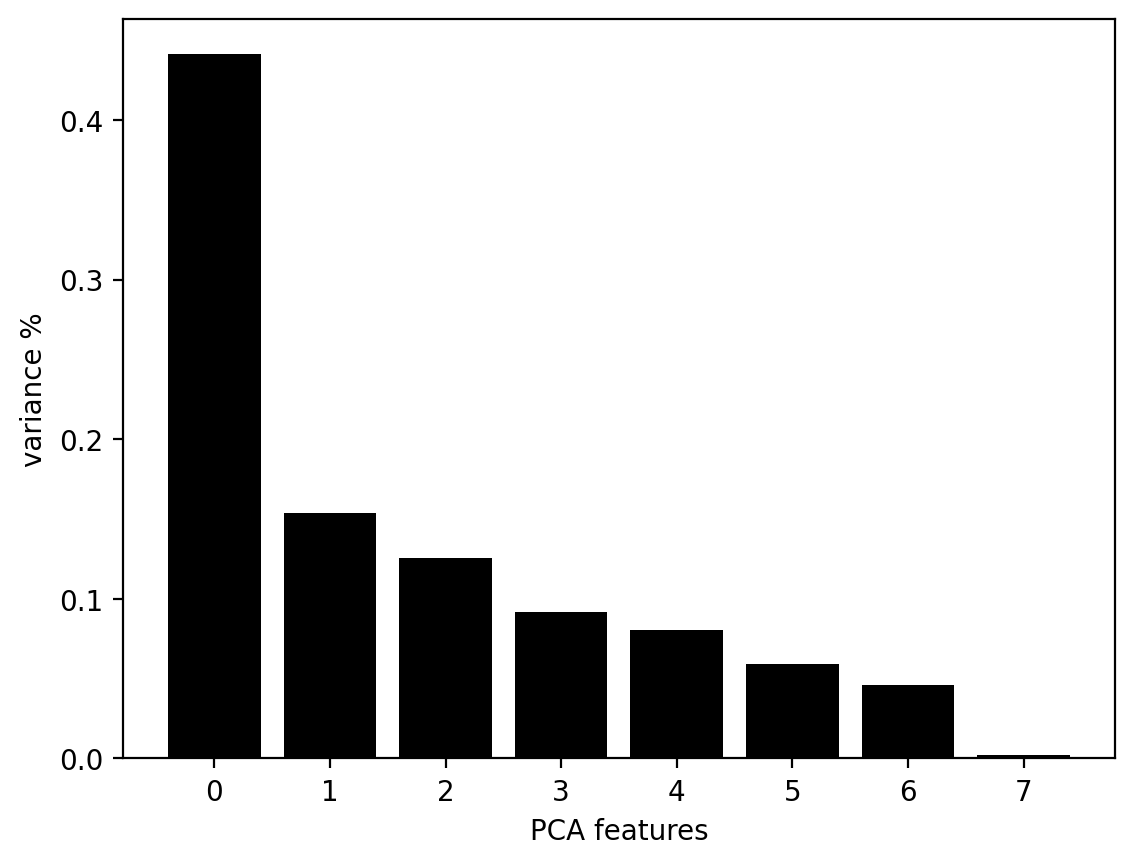

In [ ]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

Text(0, 0.5, 'Hrs Temp[<130]')

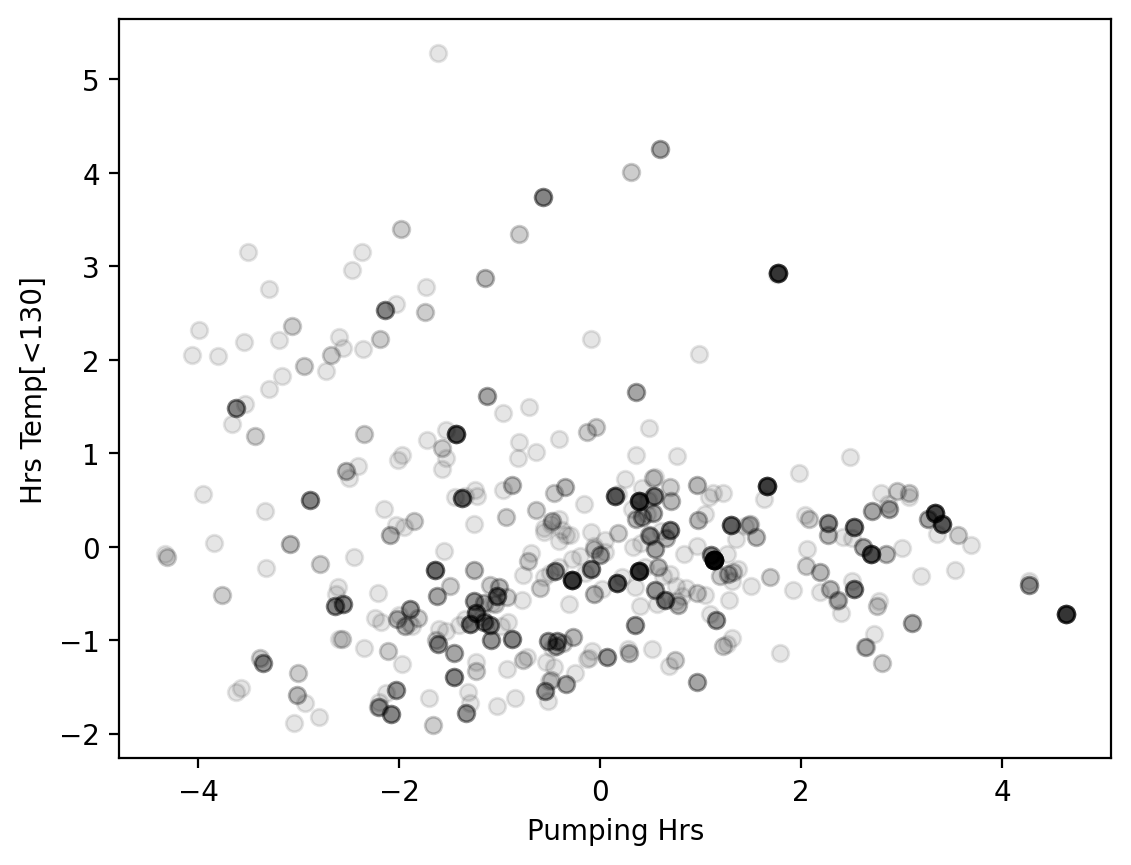

In [ ]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel(sorted_features[0])
plt.ylabel(sorted_features[1])

### Cluster identification - Elbow Method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

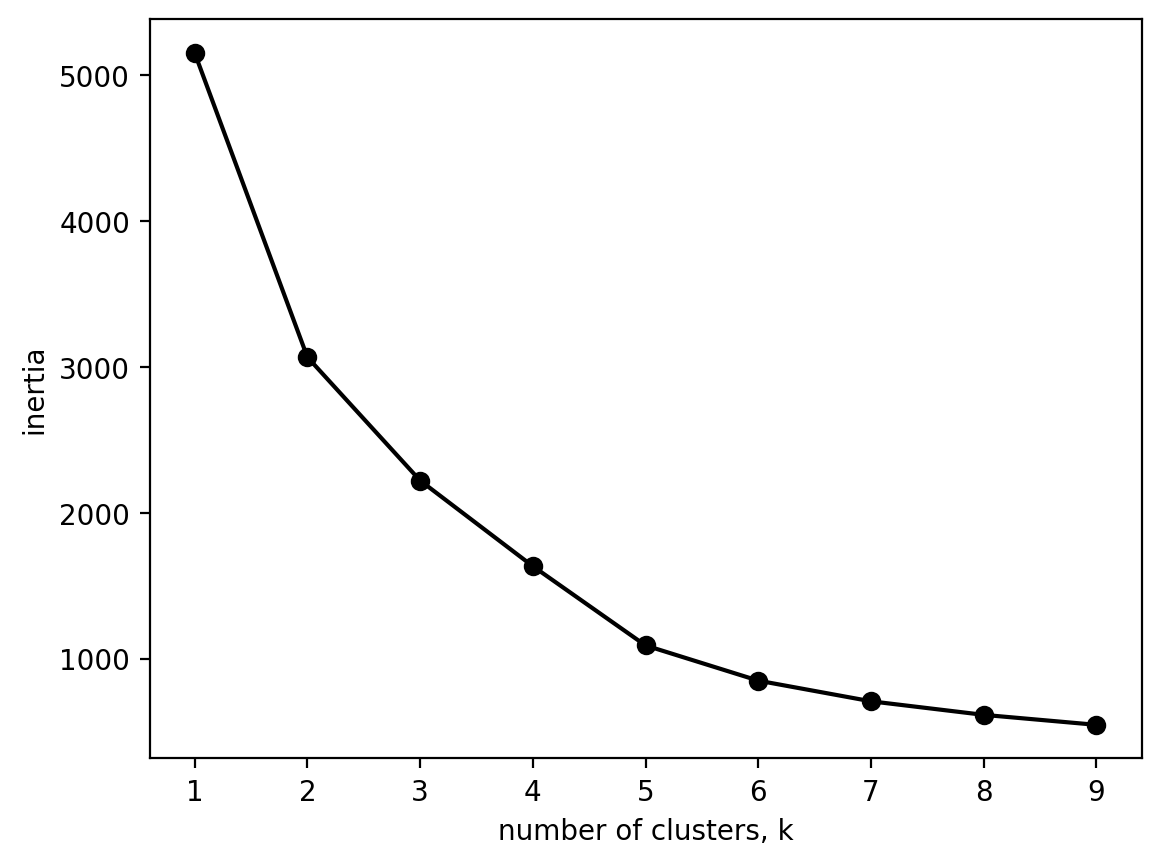

In [ ]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
kmeans =KMeans(n_clusters=3,).fit(df)
labels = kmeans.labels_
df['Risk Level'] = labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
import plotly.express as px


In [ ]:
fig = px.scatter_3d(df, x='Pumping Hrs', y='Hrs Temp[<130]', z='Max Temp', color = df['Risk Level'], height = 800, width = 1000, opacity=0.5, hover_name= df.index)
fig

In [ ]:
import plotly.express as px

# Original scatter plot
fig = px.scatter_3d(df,
                    x='Pumping Hrs',
                    y='Hrs Temp[<130]',
                    z='Max Temp',
                    color=df['Risk Level'],
                    height=800,
                    width=1000,
                    opacity=0.5,
                    hover_name=df.index)

# Select the specific element you want to change
TPSJunked = df[df['FCSN'] == '100162589.01215011']  # Replace 'Some Condition' with your condition

# Add a new trace with a different color and shape
fig.add_scatter3d(x=TPSJunked['Pumping Hrs'],
                  y=TPSJunked['Hrs Temp[<130]'],
                  z=TPSJunked['Max Temp'],
                  mode='markers',
                  marker=dict(size=10, color='red', symbol='diamond'),  # Customize the color and shape here
                  name='Special Element')

# Show the figure
fig.show()

In [ ]:
df.to_csv('Boards Data.csv')

In [ ]:
df =df.reset_index()

In [ ]:
df.index.drop_duplicates

In [ ]:
data

,FCSN,Max Temp,Hrs Temp[<130],Hrs Temp[130-150],Hrs Temp[150-175],Hrs Temp[>175],Shock Risk,Pumping Hrs,Involved in failure
0,100162589.01215011,140.000,102.633333,105.366667,0.0,0.0,1,208.0,0
1,100162589.01215011,161.000,57.766667,66.133333,148.5,0.0,0,272.4,0
2,100162589.01493011,93.000,35.000000,0.000000,0.0,0.0,1,35.0,0
3,100162589.01493011,111.000,40.400000,0.000000,0.0,0.0,1,40.4,0
4,100162589.01493011,37.000,18.600000,0.000000,0.0,0.0,1,18.6,0
...,...,...,...,...,...,...,...,...,...
36861,S-270570.113435-2,112.000,0.000000,0.000000,0.0,0.0,0,505.0,0
36867,S-270640.112992-6,112.000,0.000000,0.000000,0.0,0.0,0,505.0,0
36873,S-270780.185517-2,65.001,0.000000,0.000000,0.0,0.0,0,62.9,0
36885,S-271007.0726-4,112.000,0.000000,0.000000,0.0,0.0,0,505.0,0
